In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid', {'legend.frameon':True})

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBRegressor

from IPython.display import clear_output

# Loads

In [2]:
data = {}
for ville in ['paris', 'lyon', 'toulouse', 'nantes', 'bordeaux']:
    df = pd.read_csv('csv/%s.csv'%ville)
    X_train, X_test, y_train, y_test = train_test_split(df, df['salary_mean'], test_size=.3, random_state=0)
    data[ville] = {'X_train':X_train, 'X_test':X_test, 'y_train':y_train, 'y_test':y_test}

# Global

## metrics

In [3]:
REGR_METRICS = [
    ('r2', lambda x, y, z: r2_score(x, y)),
    ('ar2', lambda x, y, z: 1-(1-r2_score(x, y))*((len(x)-1)/(len(x)-z-1))),
    ('mae', lambda x, y, z: mean_absolute_error(x, y) / y.mean()),
    ('mse', lambda x, y, z: mean_squared_error(x, y) / (y.mean()**2)),
    ('rmse', lambda x, y, z: mean_squared_error(x, y, squared=False) / y.mean())
]

In [4]:
def get_metrics(y_test, y_pred, n_features):
    metrics = []
    for metric in REGR_METRICS:
        metrics.append(metric[1](y_test, y_pred, n_features))
    return metrics

## params

In [5]:
PARAMS = [
    {'n_estimators':range(50, 1000, 50), 'learning_rate':[.005, .001, .01, .05, .1]},
    {'objective' : ['reg:squarederror', 'reg:squaredlogerror', 'reg:pseudohubererror', 'reg:gamma', 'reg:tweedie'], 'booster' : ['gbtree' 'gblinear', 'dart'] },
    {'max_depth':list(range(2,36,2)) + [None]},
    {'subsample':[.4, .45, .5, .55, .6, .65, .7, .75, .8, .85, .9, .95, 1.0]},
    {'gamma' : [0, .1, .25, .5, 1, 10, 25, 30]}
]

## multi search

In [6]:
def multi_search(params, X_train, X_test, y_train, y_test, features, msg=''):
    full_params = {'random_state':0}
    metrics = []
    i = 0
    print('{}/{} - {:.2f} - {}'.format(i, len(params), i / len(params) * 100, msg))
    for p in params:
        search = GridSearchCV(XGBRegressor(**full_params), p, n_jobs=4, cv=5, verbose=1).fit(X_train[features], y_train)
        full_params.update(search.best_params_)
        y_pred = search.best_estimator_.predict(X_test[features])
        metrics.append(get_metrics(y_test, y_pred, len(features)))
        i+=1
        clear_output(wait=True)
        print('{}/{} - {:.2f} - {}'.format(i, len(params), i / len(params) * 100, msg))
        print(search.best_params_)
        print(search.best_estimator_.get_params())
    return full_params, metrics

## n_row

In [7]:
def n_row_search(params, X_train, X_test, y_train, y_test, features, row_step=10, msg=''):
    metrics = []
    row_count = len(y_train)
    search = np.empty((int(np.ceil(row_count/row_step)), len(REGR_METRICS)))
    i = 0
    print('{}/{} - {:.2f} - {}'.format(i, row_count, i / row_count * 100, msg))
    while i < row_count:
        i = min(i + row_step, row_count)
        model = XGBRegressor(**params).fit(X_train[features][:i], y_train[:i])
        y_pred = model.predict(X_test[features])
        metrics.append(get_metrics(y_test, y_pred, len(features)))
        clear_output(wait=True)
        print('{}/{} - {:.2f} - {}'.format(i, row_count, i / row_count * 100, msg))
    return (metrics, model.feature_importances_)

## plot search

In [8]:
def plot_searchs(params, grid_metrics, n_row_metrics, feature_importances, features):
    print("\nModel Report\n")
    print('Features : %s\n'%features)
    print('Params : %s\n'%params)
    print('R2 : %s'%np.max(grid_metrics[:,0]))
    print('AR2 : %s'%np.max(grid_metrics[:,1]))
    print('MAE/MEAN : %s'%np.min(grid_metrics[:,2]))
    print('MSE/MEAN² : %s'%np.min(grid_metrics[:,3]))
    print('RMSE/MEAN : %s'%np.min(grid_metrics[:,4]))
    
    fig, axs = plt.subplots(1,2, figsize=(20,5))
    fig.suptitle('Perfomance of the model')
    axs[0].plot(np.arange(grid_metrics.shape[0]), grid_metrics[:,0])
    axs[0].set_title('GridSearch R² evolution')
    axs[1].plot(np.arange(n_row_metrics.shape[0]), n_row_metrics[:,0])
    axs[1].set_title('n_row R² evolution')
    plt.show()
    pd.Series(feature_importances, features).sort_values(ascending=False).plot(figsize=(20,5), kind='bar', title='Feature Importances')
    plt.show()
    

## plot model

In [13]:
def plot_pred(params, X_train, X_test, y_train, y_test, features):
    y_pred = XGBRegressor(**params).fit(X_train[features], y_train).predict(X_test[features])
    res = pd.DataFrame([(y_test.to_numpy()[i], y_pred[i]) for i in range(len(y_test))], columns=['true', 'pred']).sort_values('true')
    res['pred-mae'] = res['pred'] - mean_absolute_error(y_test, y_pred)
    res['pred+mae'] = res['pred'] + mean_absolute_error(y_test, y_pred)
#     print(res)
    plt.plot(np.arange(len(res)), res['true'])
    plt.plot(np.arange(len(res)), res['pred'])
    plt.show()


# Without query

In [16]:
features = list(df.columns[1:14])
for key, value in data.items():
    clear_output(wait=True)
    params, grid_metrics = multi_search(PARAMS, value['X_train'], value['X_test'], value['y_train'], value['y_test'], features, msg=key)
    n_row_metrics, feature_importances = n_row_search(params, value['X_train'], value['X_test'], value['y_train'], value['y_test'], features, msg=key)
    data[key].update({'params':params, 'grid_metrics':grid_metrics, 'n_row_metrics':n_row_metrics, 'feature_importances':feature_importances})

70/70 - 100.00 - bordeaux


paris


Model Report

Features : ['rating_mean', 'rating_count', 'contract_contrat pro', 'contract_intérim', 'contract_temps plein', 'contract_indépendant', 'contract_cdd', 'contract_temps partiel', 'contract_cdi', 'contract_stage', 'contract_commission', 'contract_apprentissage', 'mode_an']

Params : {'random_state': 0, 'learning_rate': 0.005, 'n_estimators': 600, 'booster': 'dart', 'objective': 'reg:squarederror', 'max_depth': 2, 'subsample': 1.0, 'gamma': 0}

R2 : 0.7036597440641079
AR2 : 0.6767197207972087
MAE/MEAN : 0.17346946036187158
MSE/MEAN² : 0.07327387130035846
RMSE/MEAN : 0.27069146883557016


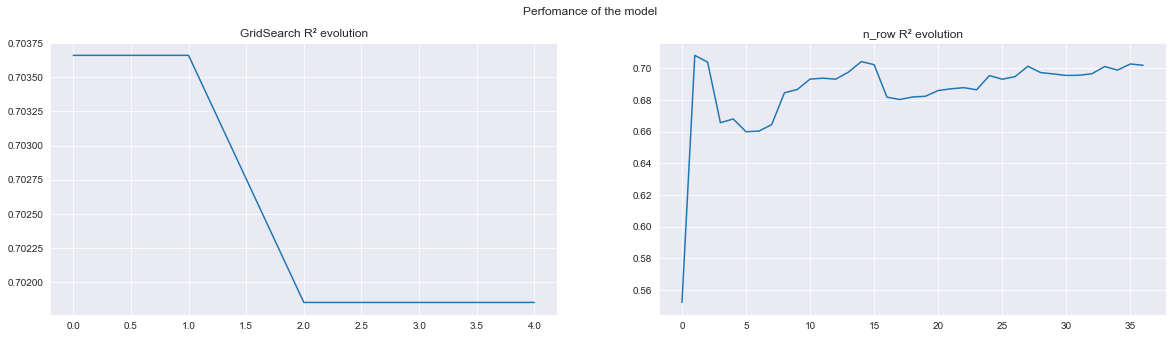

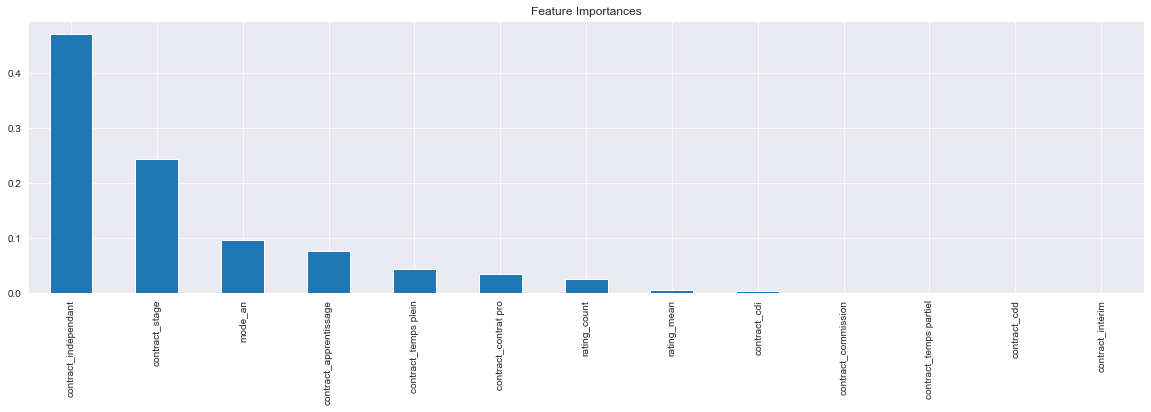

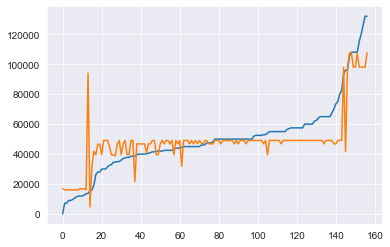

lyon


Model Report

Features : ['rating_mean', 'rating_count', 'contract_contrat pro', 'contract_intérim', 'contract_temps plein', 'contract_indépendant', 'contract_cdd', 'contract_temps partiel', 'contract_cdi', 'contract_stage', 'contract_commission', 'contract_apprentissage', 'mode_an']

Params : {'random_state': 0, 'learning_rate': 0.01, 'n_estimators': 350, 'booster': 'dart', 'objective': 'reg:squarederror', 'max_depth': 4, 'subsample': 0.65, 'gamma': 0}

R2 : 0.7242547026495209
AR2 : 0.6188226771919847
MAE/MEAN : 0.15778189193946082
MSE/MEAN² : 0.05940524699698491
RMSE/MEAN : 0.24373191624607746


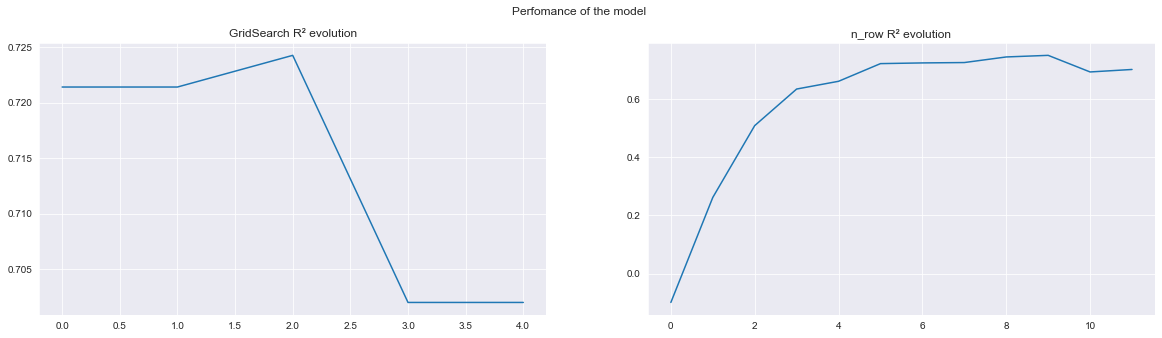

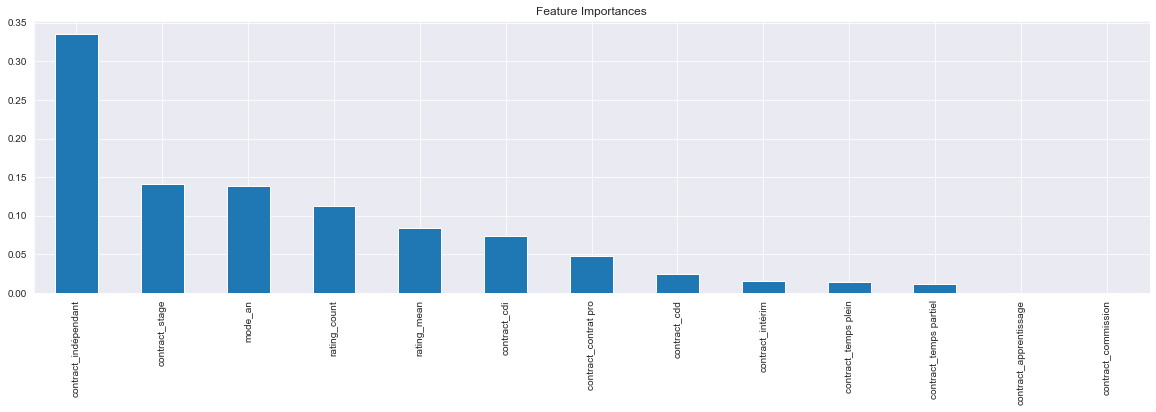

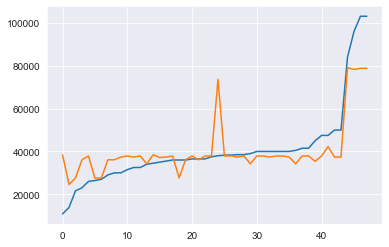

toulouse


Model Report

Features : ['rating_mean', 'rating_count', 'contract_contrat pro', 'contract_intérim', 'contract_temps plein', 'contract_indépendant', 'contract_cdd', 'contract_temps partiel', 'contract_cdi', 'contract_stage', 'contract_commission', 'contract_apprentissage', 'mode_an']

Params : {'random_state': 0, 'learning_rate': 0.005, 'n_estimators': 650, 'booster': 'dart', 'objective': 'reg:squarederror', 'max_depth': 4, 'subsample': 1.0, 'gamma': 0}

R2 : 0.1586267446118239
AR2 : -0.9351584873928049
MAE/MEAN : 0.20227125133237314
MSE/MEAN² : 0.10233043549263056
RMSE/MEAN : 0.31989128699080027


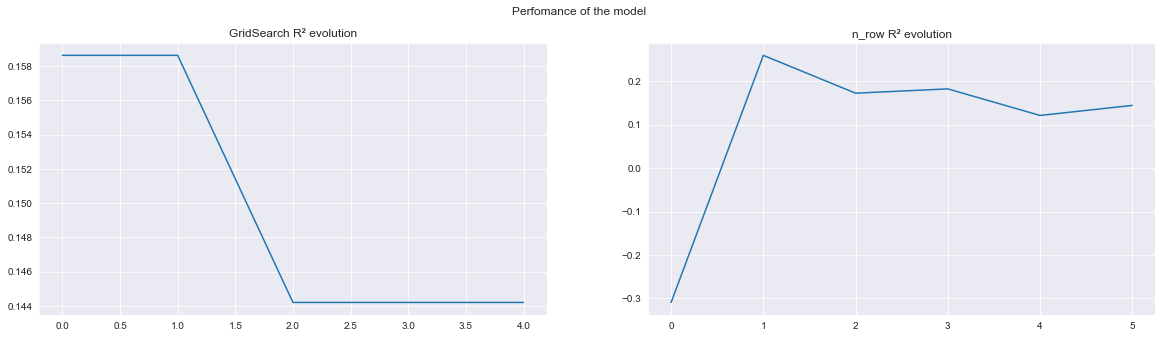

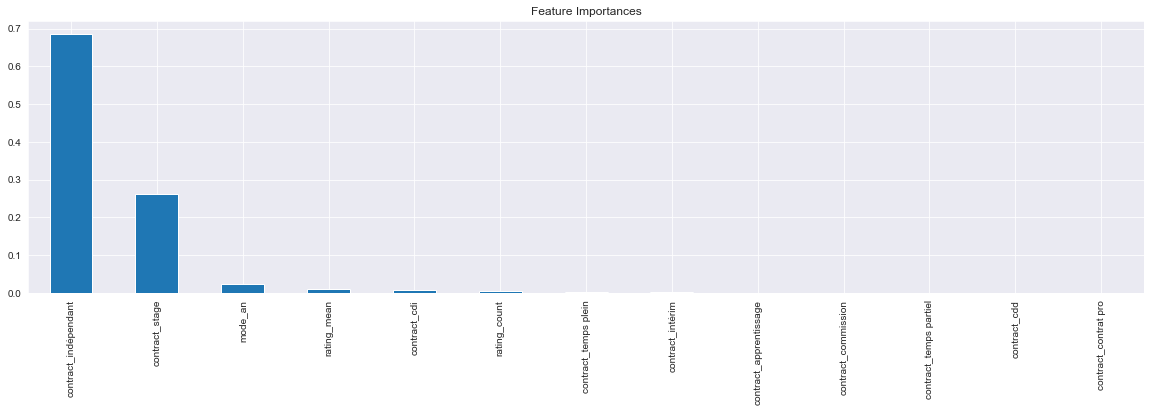

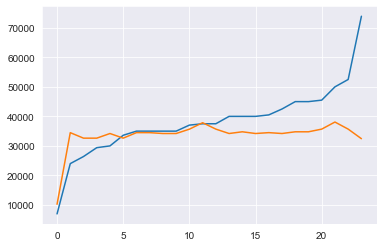

nantes


Model Report

Features : ['rating_mean', 'rating_count', 'contract_contrat pro', 'contract_intérim', 'contract_temps plein', 'contract_indépendant', 'contract_cdd', 'contract_temps partiel', 'contract_cdi', 'contract_stage', 'contract_commission', 'contract_apprentissage', 'mode_an']

Params : {'random_state': 0, 'learning_rate': 0.05, 'n_estimators': 50, 'booster': 'dart', 'objective': 'reg:squarederror', 'max_depth': 2, 'subsample': 0.5, 'gamma': 0}

R2 : 0.255142869446511
AR2 : 0.03996192061994741
MAE/MEAN : 0.2127516700548633
MSE/MEAN² : 0.09451377038166954
RMSE/MEAN : 0.30743091969037456


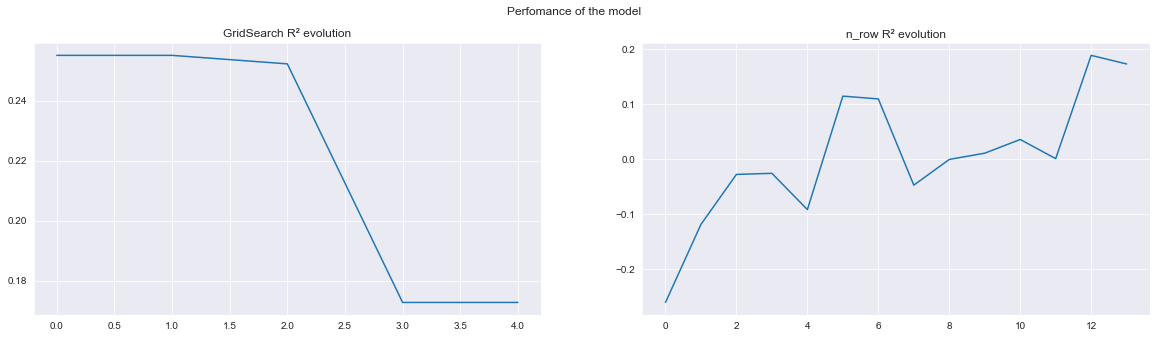

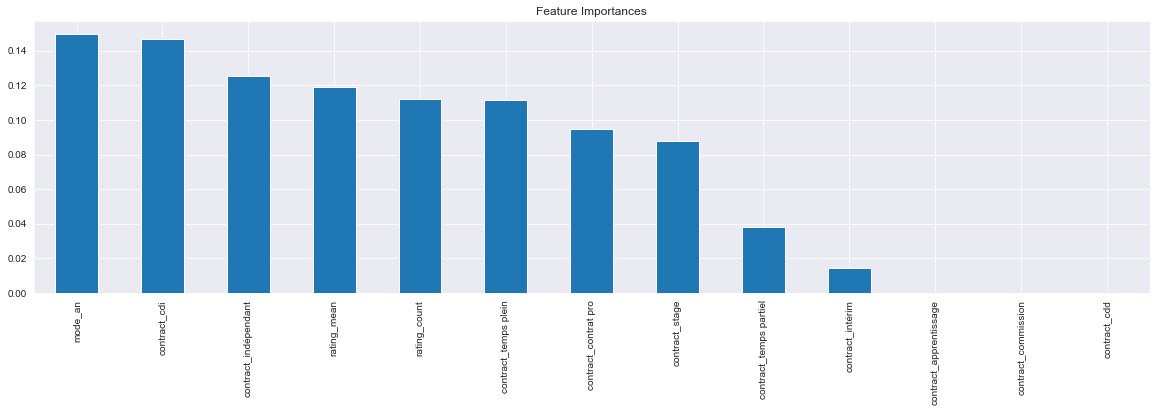

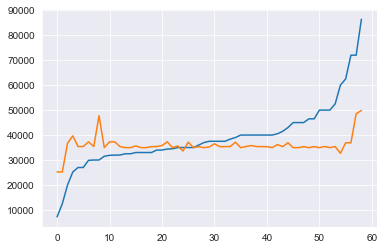

bordeaux


Model Report

Features : ['rating_mean', 'rating_count', 'contract_contrat pro', 'contract_intérim', 'contract_temps plein', 'contract_indépendant', 'contract_cdd', 'contract_temps partiel', 'contract_cdi', 'contract_stage', 'contract_commission', 'contract_apprentissage', 'mode_an']

Params : {'random_state': 0, 'learning_rate': 0.01, 'n_estimators': 900, 'booster': 'dart', 'objective': 'reg:squarederror', 'max_depth': 6, 'subsample': 1.0, 'gamma': 30}

R2 : 0.5449086650399171
AR2 : 0.19689764418808897
MAE/MEAN : 0.14863262347389067
MSE/MEAN² : 0.03699202647286974
RMSE/MEAN : 0.19233311330311725


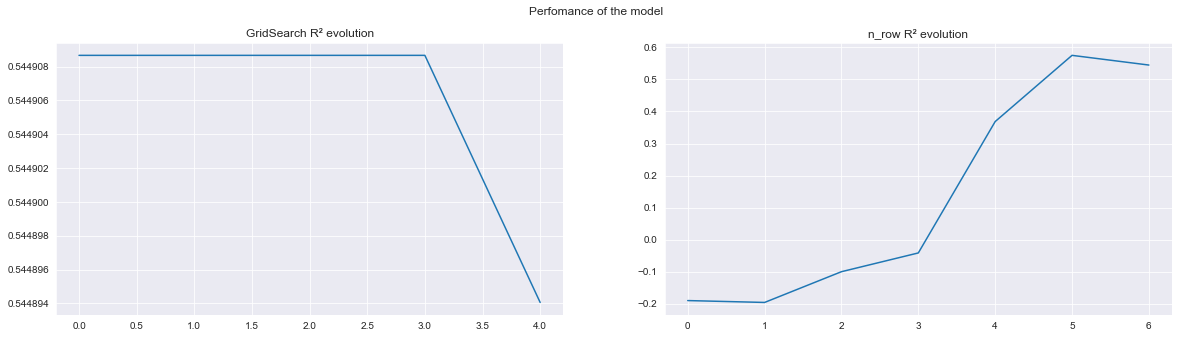

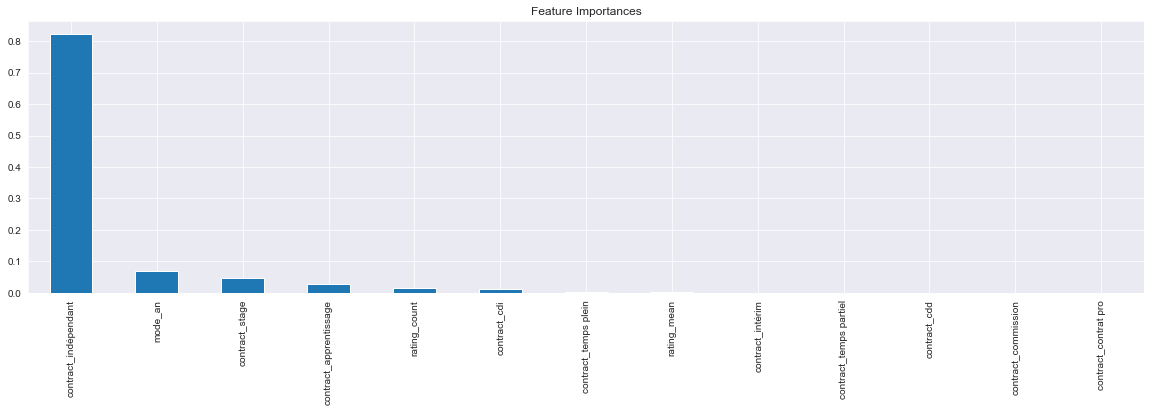

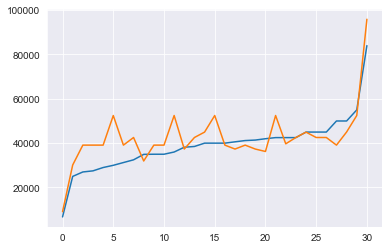

In [17]:
features = list(df.columns[1:14])
for key, value in data.items():
    print('{}\n'.format(key))
    plot_searchs(value['params'], np.array(value['grid_metrics']), np.array(value['n_row_metrics']), value['feature_importances'], features)
    plot_pred(value['params'], value['X_train'], value['X_test'], value['y_train'], value['y_test'], features)

# With query

In [18]:
features = list(df.columns[1:14]) + list(df.columns[18:])
for key, value in data.items():
    clear_output(wait=True)
    params, grid_metrics = multi_search(PARAMS, value['X_train'], value['X_test'], value['y_train'], value['y_test'], features, msg=key)
    n_row_metrics, feature_importances = n_row_search(params, value['X_train'], value['X_test'], value['y_train'], value['y_test'], features, msg=key)
    data[key].update({'params':params, 'grid_metrics':grid_metrics, 'n_row_metrics':n_row_metrics, 'feature_importances':feature_importances})

70/70 - 100.00 - bordeaux


paris


Model Report

Features : ['rating_mean', 'rating_count', 'contract_contrat pro', 'contract_intérim', 'contract_temps plein', 'contract_indépendant', 'contract_cdd', 'contract_temps partiel', 'contract_cdi', 'contract_stage', 'contract_commission', 'contract_apprentissage', 'mode_an', 'query_data+scientist', 'query_business+intelligence', 'query_data+analyst', 'query_developpeur']

Params : {'random_state': 0, 'learning_rate': 0.005, 'n_estimators': 600, 'booster': 'dart', 'objective': 'reg:squarederror', 'max_depth': 2, 'subsample': 1.0, 'gamma': 0}

R2 : 0.7076178512191948
AR2 : 0.6718588833826935
MAE/MEAN : 0.1722454714779557
MSE/MEAN² : 0.07271129703366015
RMSE/MEAN : 0.26965032362980795


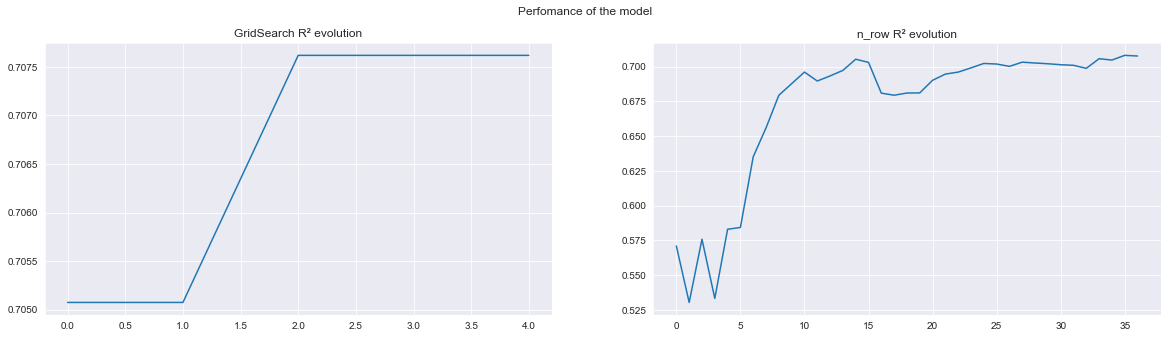

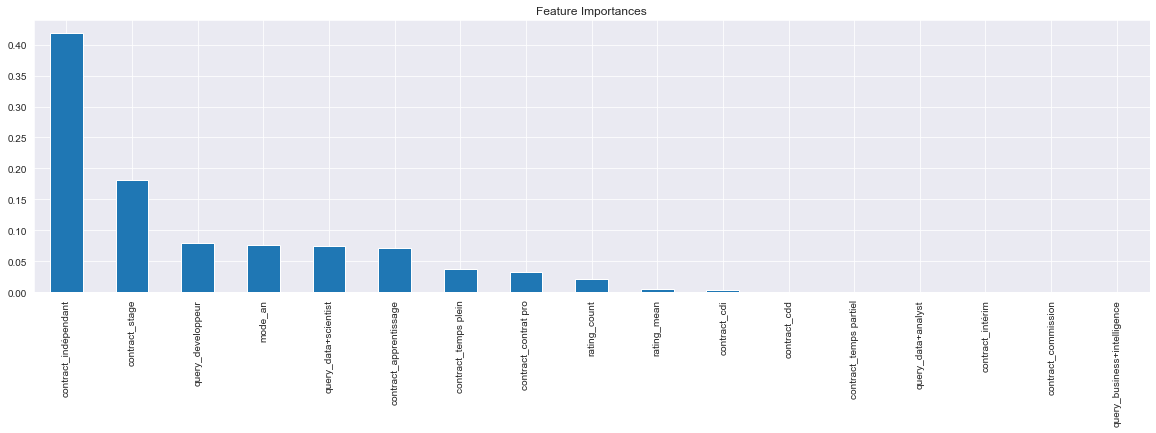

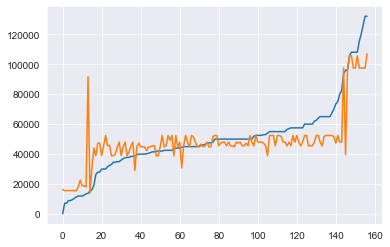

lyon


Model Report

Features : ['rating_mean', 'rating_count', 'contract_contrat pro', 'contract_intérim', 'contract_temps plein', 'contract_indépendant', 'contract_cdd', 'contract_temps partiel', 'contract_cdi', 'contract_stage', 'contract_commission', 'contract_apprentissage', 'mode_an', 'query_data+scientist', 'query_business+intelligence', 'query_data+analyst', 'query_developpeur']

Params : {'random_state': 0, 'learning_rate': 0.01, 'n_estimators': 350, 'booster': 'dart', 'objective': 'reg:squarederror', 'max_depth': 6, 'subsample': 0.75, 'gamma': 0}

R2 : 0.7238020244396604
AR2 : 0.5672898382888012
MAE/MEAN : 0.15793083739194297
MSE/MEAN² : 0.06024394090379825
RMSE/MEAN : 0.24544641147060647


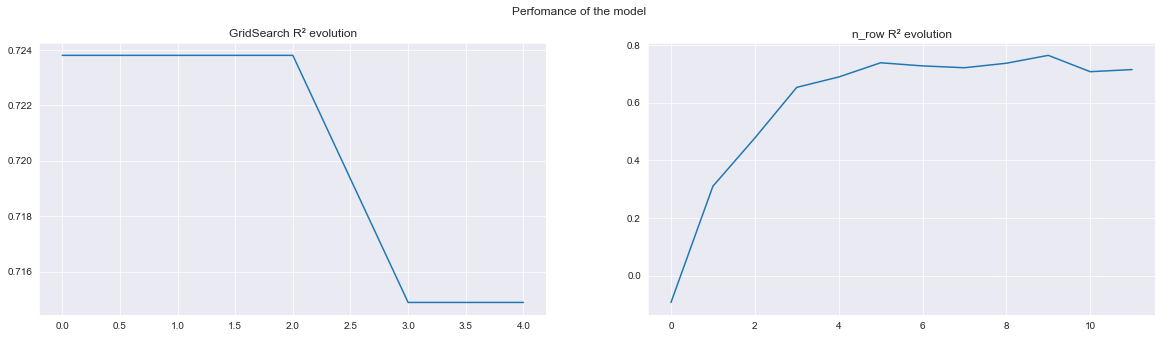

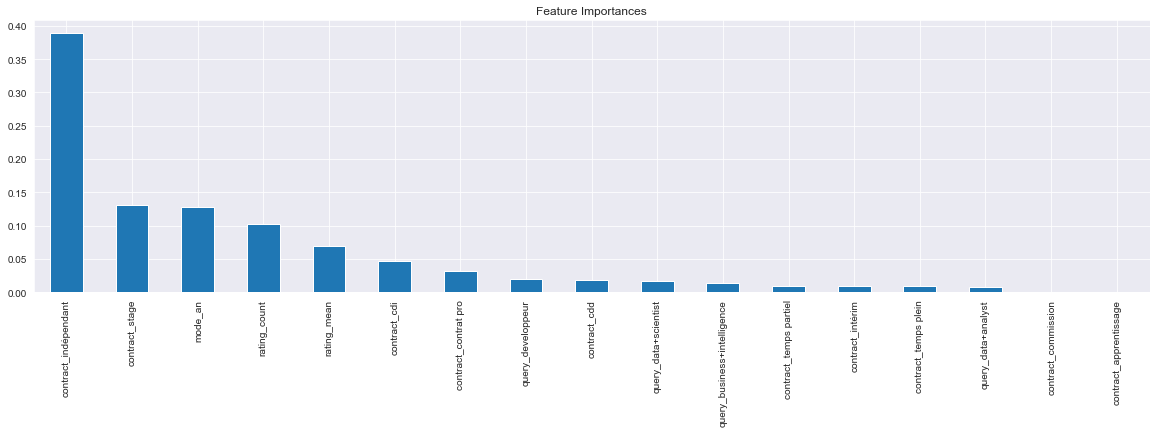

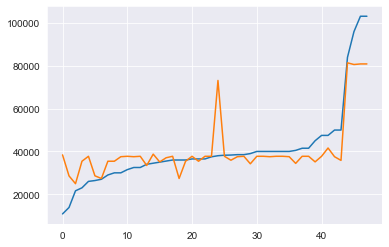

toulouse


Model Report

Features : ['rating_mean', 'rating_count', 'contract_contrat pro', 'contract_intérim', 'contract_temps plein', 'contract_indépendant', 'contract_cdd', 'contract_temps partiel', 'contract_cdi', 'contract_stage', 'contract_commission', 'contract_apprentissage', 'mode_an', 'query_data+scientist', 'query_business+intelligence', 'query_data+analyst', 'query_developpeur']

Params : {'random_state': 0, 'learning_rate': 0.005, 'n_estimators': 750, 'booster': 'dart', 'objective': 'reg:squarederror', 'max_depth': 2, 'subsample': 0.85, 'gamma': 0}

R2 : 0.11671983506131145
AR2 : -2.3859072989316394
MAE/MEAN : 0.20922756145520002
MSE/MEAN² : 0.1079604930344469
RMSE/MEAN : 0.3285734210712225


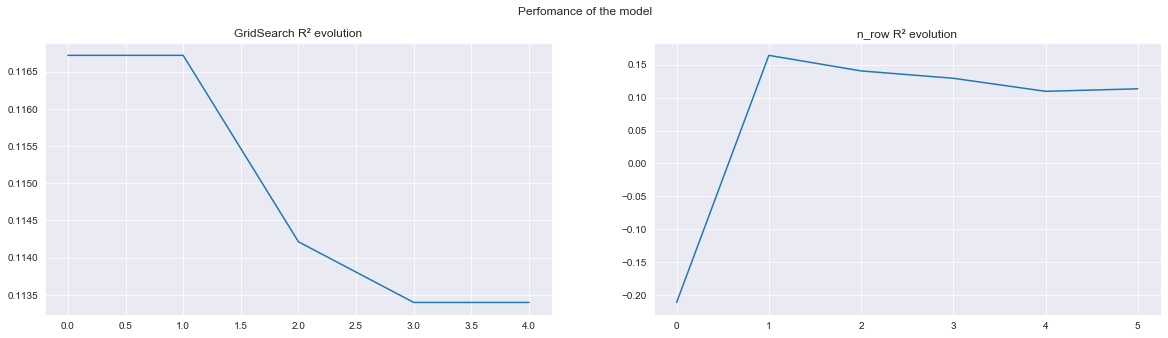

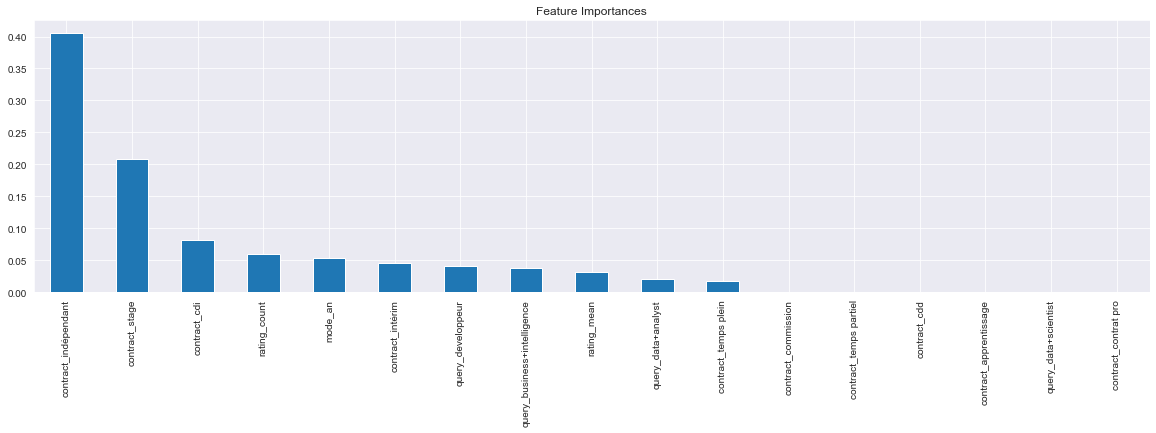

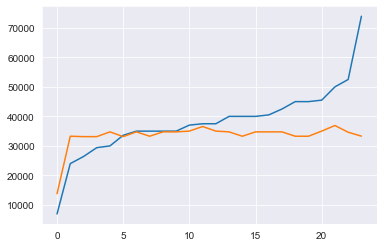

nantes


Model Report

Features : ['rating_mean', 'rating_count', 'contract_contrat pro', 'contract_intérim', 'contract_temps plein', 'contract_indépendant', 'contract_cdd', 'contract_temps partiel', 'contract_cdi', 'contract_stage', 'contract_commission', 'contract_apprentissage', 'mode_an', 'query_data+scientist', 'query_business+intelligence', 'query_data+analyst', 'query_developpeur']

Params : {'random_state': 0, 'learning_rate': 0.05, 'n_estimators': 50, 'booster': 'dart', 'objective': 'reg:squarederror', 'max_depth': 2, 'subsample': 0.5, 'gamma': 0}

R2 : 0.25494064082083445
AR2 : -0.05398641054613651
MAE/MEAN : 0.2125451383055136
MSE/MEAN² : 0.09481170753266262
RMSE/MEAN : 0.30791509792905997


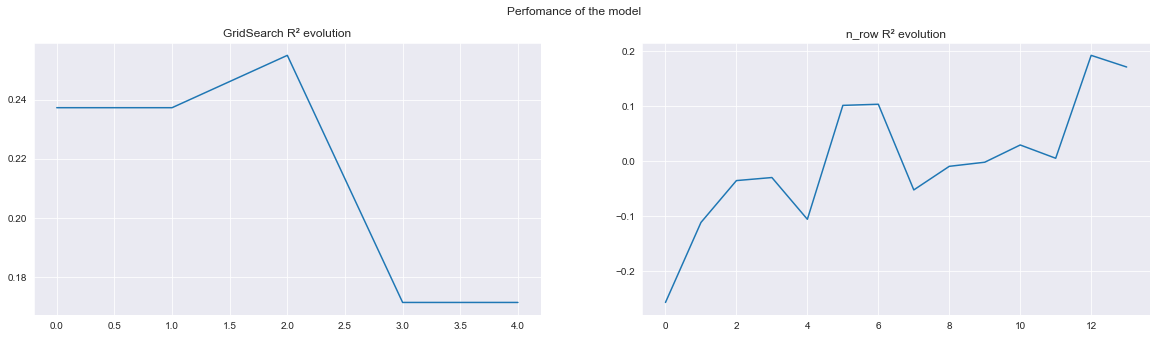

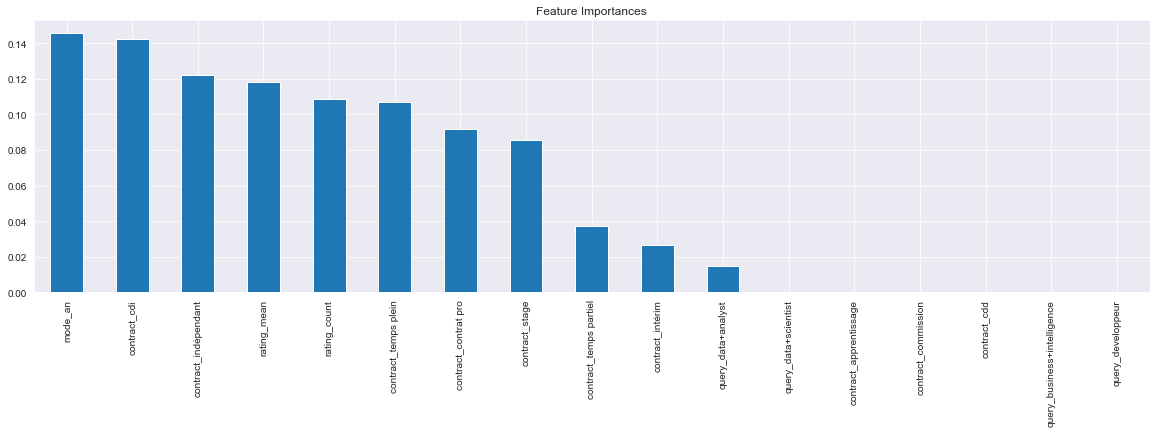

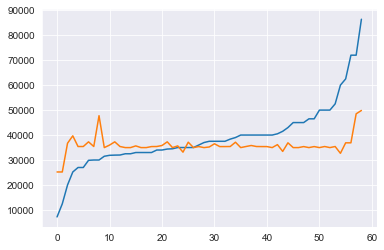

bordeaux


Model Report

Features : ['rating_mean', 'rating_count', 'contract_contrat pro', 'contract_intérim', 'contract_temps plein', 'contract_indépendant', 'contract_cdd', 'contract_temps partiel', 'contract_cdi', 'contract_stage', 'contract_commission', 'contract_apprentissage', 'mode_an', 'query_data+scientist', 'query_business+intelligence', 'query_data+analyst', 'query_developpeur']

Params : {'random_state': 0, 'learning_rate': 0.1, 'n_estimators': 50, 'booster': 'dart', 'objective': 'reg:squarederror', 'max_depth': 4, 'subsample': 1.0, 'gamma': 0}

R2 : 0.616977013265136
AR2 : 0.11610079984262156
MAE/MEAN : 0.13895317276175395
MSE/MEAN² : 0.033079597198050426
RMSE/MEAN : 0.1818779733723972


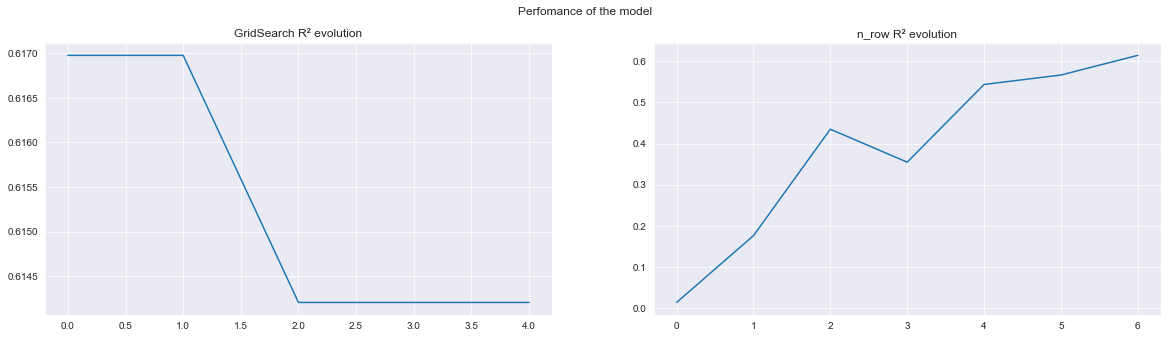

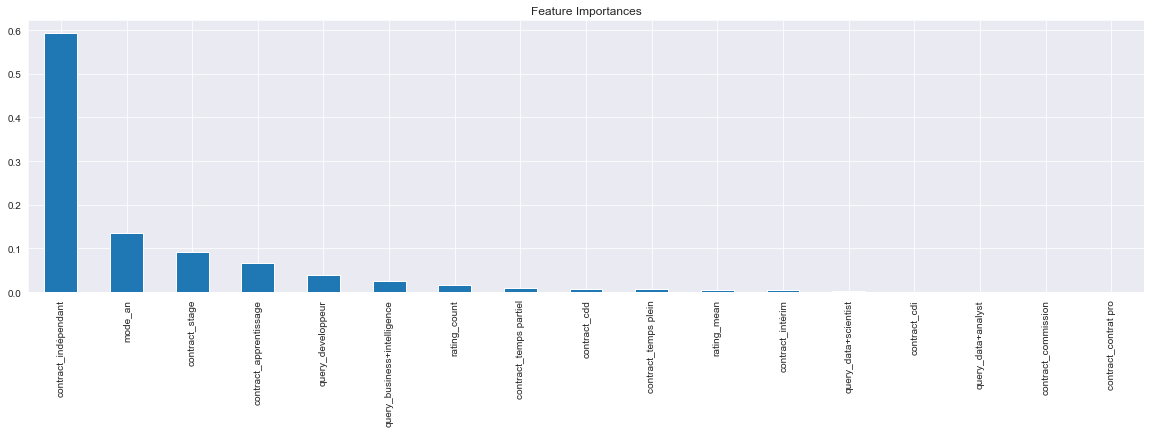

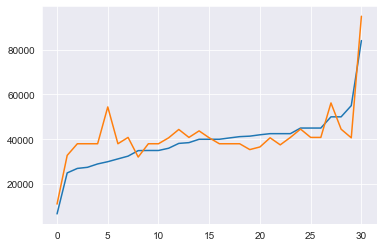

In [19]:
features = list(df.columns[1:14]) + list(df.columns[18:])
for key, value in data.items():
    print('{}\n'.format(key))
    plot_searchs(value['params'], np.array(value['grid_metrics']), np.array(value['n_row_metrics']), value['feature_importances'], features)
    plot_pred(value['params'], value['X_train'], value['X_test'], value['y_train'], value['y_test'], features)

# Without ratings

In [33]:
features = list(df.columns[3:14]) + list(df.columns[18:])
for key, value in data.items():
    clear_output(wait=True)
    params, grid_metrics = multi_search(PARAMS, value['X_train'], value['X_test'], value['y_train'], value['y_test'], features, msg=key)
    n_row_metrics, feature_importances = n_row_search(params, value['X_train'], value['X_test'], value['y_train'], value['y_test'], features, msg=key)
    data[key].update({'params':params, 'grid_metrics':grid_metrics, 'n_row_metrics':n_row_metrics, 'feature_importances':feature_importances})

70/70 - 100.00 - bordeaux


paris


Model Report

Features : ['contract_contrat pro', 'contract_intérim', 'contract_temps plein', 'contract_indépendant', 'contract_cdd', 'contract_temps partiel', 'contract_cdi', 'contract_stage', 'contract_commission', 'contract_apprentissage', 'mode_an', 'query_data+scientist', 'query_business+intelligence', 'query_data+analyst', 'query_developpeur']

Params : {'random_state': 0, 'learning_rate': 0.005, 'n_estimators': 600, 'booster': 'dart', 'objective': 'reg:squarederror', 'max_depth': 2, 'subsample': 1.0, 'gamma': 0}

R2 : 0.715447716390042
AR2 : 0.6851761968570678
MAE/MEAN : 0.17021208473221638
MSE/MEAN² : 0.07148501588958724
RMSE/MEAN : 0.26736681897645276


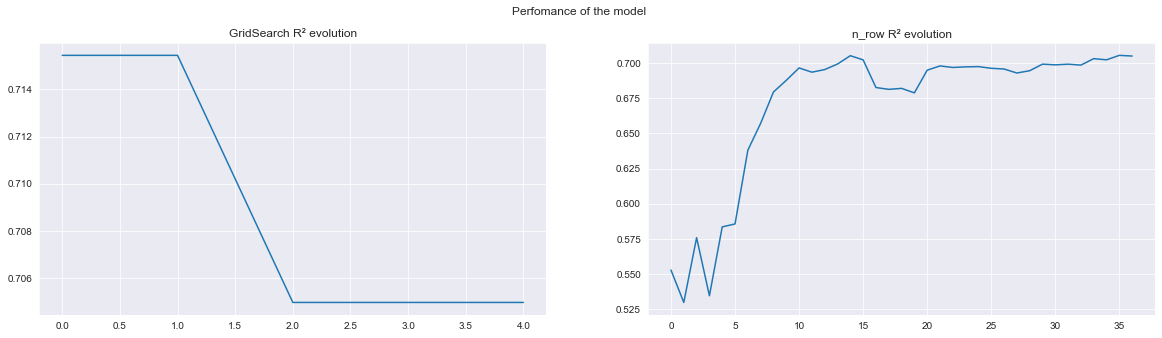

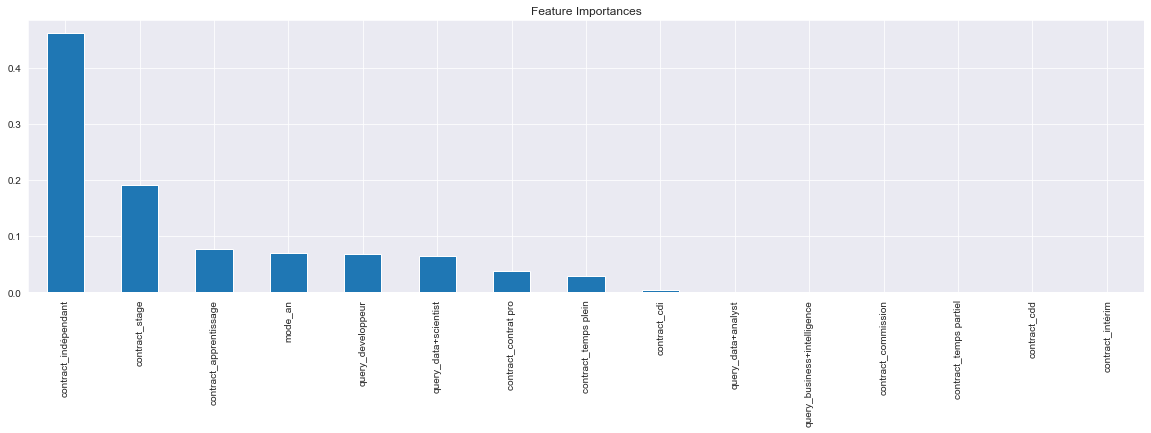

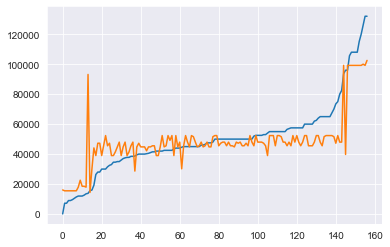

lyon


Model Report

Features : ['contract_contrat pro', 'contract_intérim', 'contract_temps plein', 'contract_indépendant', 'contract_cdd', 'contract_temps partiel', 'contract_cdi', 'contract_stage', 'contract_commission', 'contract_apprentissage', 'mode_an', 'query_data+scientist', 'query_business+intelligence', 'query_data+analyst', 'query_developpeur']

Params : {'random_state': 0, 'learning_rate': 0.005, 'n_estimators': 600, 'booster': 'dart', 'objective': 'reg:squarederror', 'max_depth': 4, 'subsample': 1.0, 'gamma': 0}

R2 : 0.7563206800277741
AR2 : 0.6420959987907933
MAE/MEAN : 0.16566116424029115
MSE/MEAN² : 0.05515676380807565
RMSE/MEAN : 0.23485477173793096


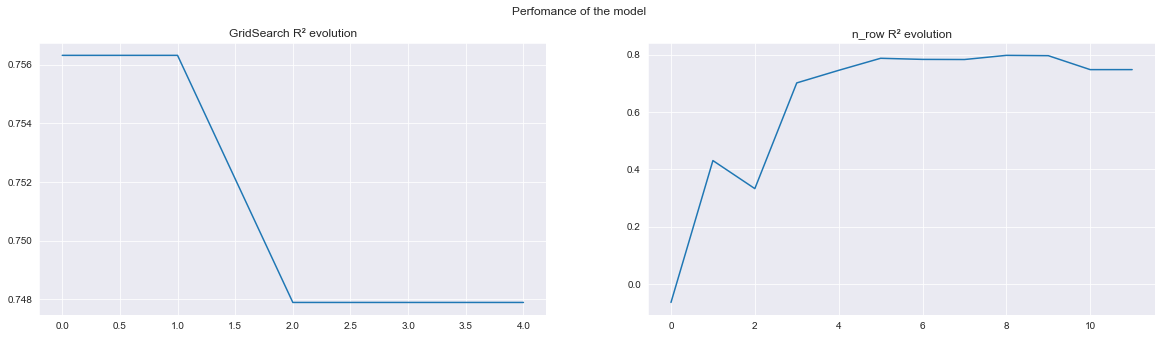

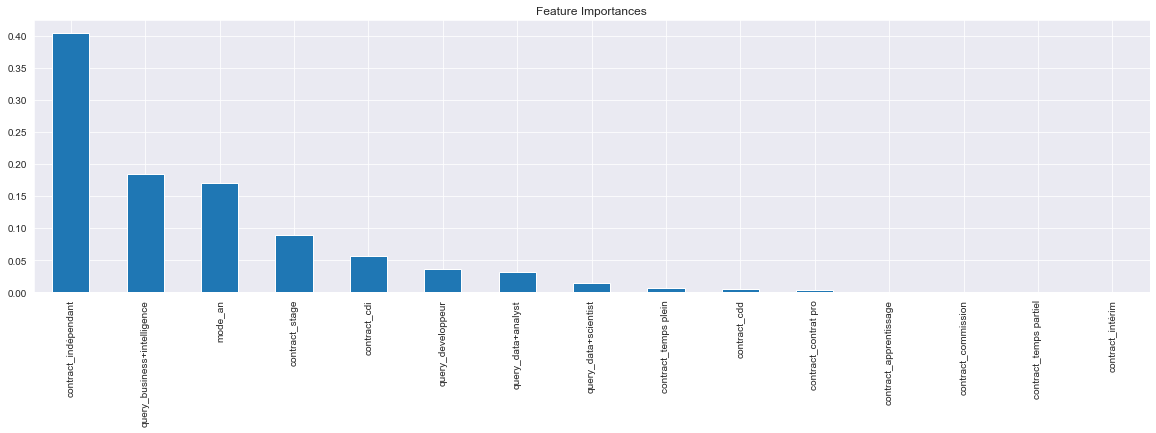

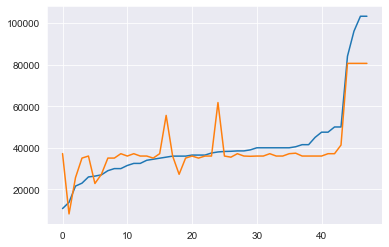

toulouse


Model Report

Features : ['contract_contrat pro', 'contract_intérim', 'contract_temps plein', 'contract_indépendant', 'contract_cdd', 'contract_temps partiel', 'contract_cdi', 'contract_stage', 'contract_commission', 'contract_apprentissage', 'mode_an', 'query_data+scientist', 'query_business+intelligence', 'query_data+analyst', 'query_developpeur']

Params : {'random_state': 0, 'learning_rate': 0.005, 'n_estimators': 850, 'booster': 'dart', 'objective': 'reg:squarederror', 'max_depth': 4, 'subsample': 0.6, 'gamma': 0}

R2 : 0.023197547647439087
AR2 : -1.8083070505136125
MAE/MEAN : 0.2225723849811969
MSE/MEAN² : 0.12265919440346887
RMSE/MEAN : 0.35022734673847056


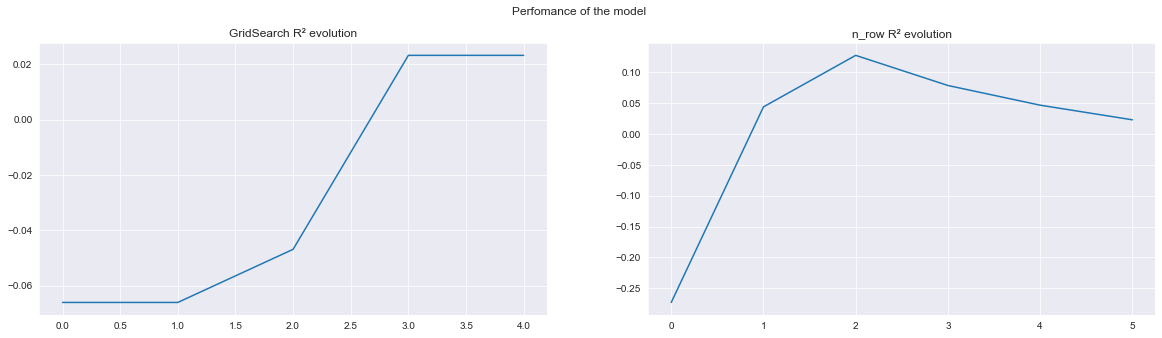

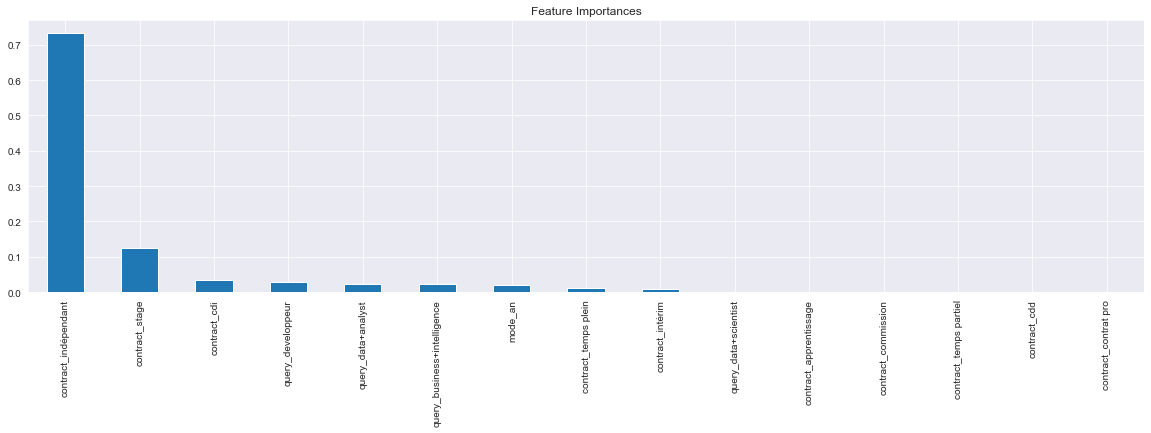

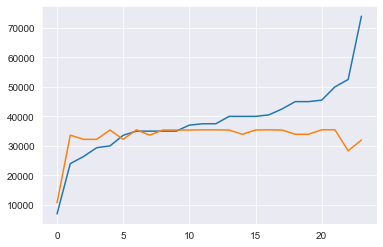

nantes


Model Report

Features : ['contract_contrat pro', 'contract_intérim', 'contract_temps plein', 'contract_indépendant', 'contract_cdd', 'contract_temps partiel', 'contract_cdi', 'contract_stage', 'contract_commission', 'contract_apprentissage', 'mode_an', 'query_data+scientist', 'query_business+intelligence', 'query_data+analyst', 'query_developpeur']

Params : {'random_state': 0, 'learning_rate': 0.005, 'n_estimators': 650, 'booster': 'dart', 'objective': 'reg:squarederror', 'max_depth': 2, 'subsample': 0.45, 'gamma': 0}

R2 : 0.3161966355264728
AR2 : 0.07766057815198657
MAE/MEAN : 0.19987515141618095
MSE/MEAN² : 0.07958672203521246
RMSE/MEAN : 0.28211118736273555


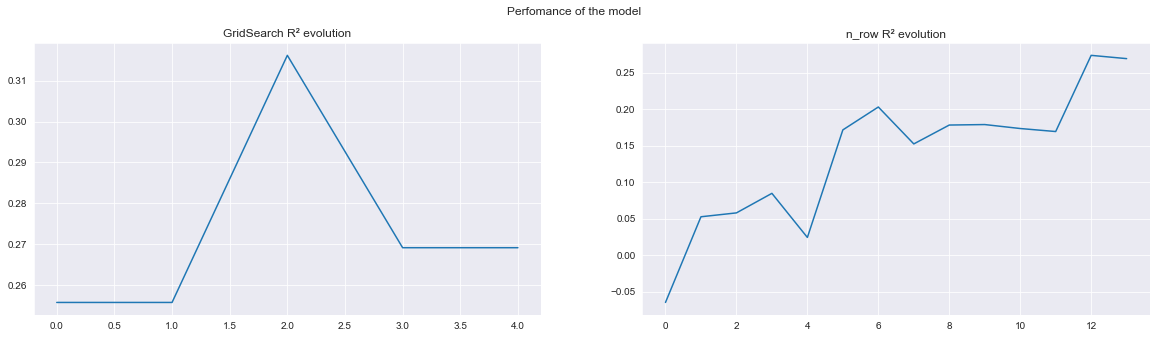

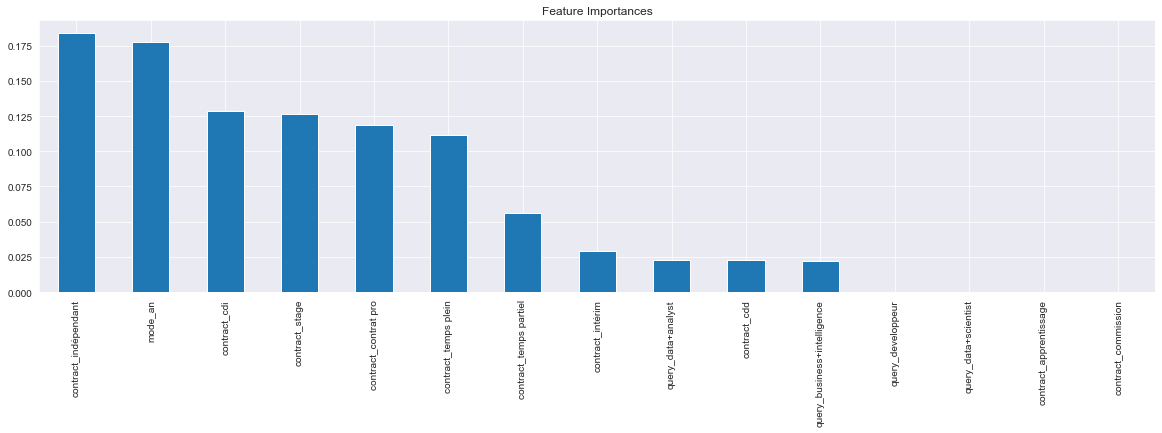

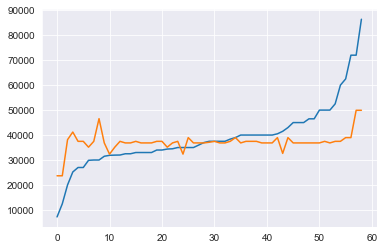

bordeaux


Model Report

Features : ['contract_contrat pro', 'contract_intérim', 'contract_temps plein', 'contract_indépendant', 'contract_cdd', 'contract_temps partiel', 'contract_cdi', 'contract_stage', 'contract_commission', 'contract_apprentissage', 'mode_an', 'query_data+scientist', 'query_business+intelligence', 'query_data+analyst', 'query_developpeur']

Params : {'random_state': 0, 'learning_rate': 0.1, 'n_estimators': 950, 'booster': 'dart', 'objective': 'reg:squarederror', 'max_depth': 2, 'subsample': 1.0, 'gamma': 1}

R2 : 0.4693843135690343
AR2 : -0.061231372861931366
MAE/MEAN : 0.16279970051707682
MSE/MEAN² : 0.04476753203682484
RMSE/MEAN : 0.21158339263000972


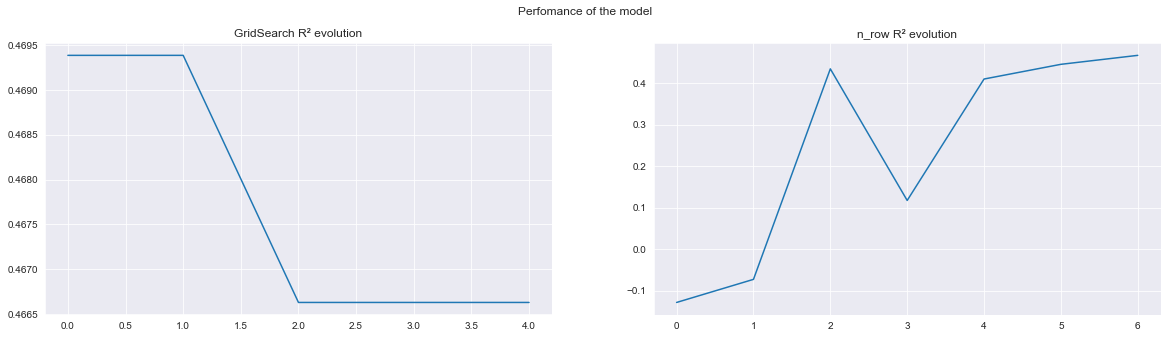

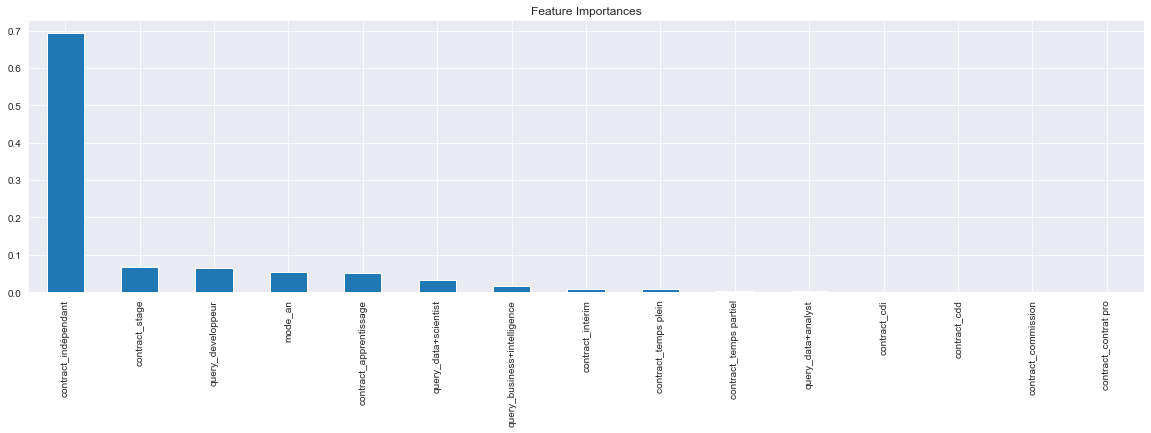

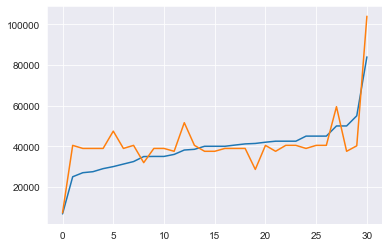

In [34]:
features = list(df.columns[3:14]) + list(df.columns[18:])
for key, value in data.items():
    print('{}\n'.format(key))
    plot_searchs(value['params'], np.array(value['grid_metrics']), np.array(value['n_row_metrics']), value['feature_importances'], features)
    plot_pred(value['params'], value['X_train'], value['X_test'], value['y_train'], value['y_test'], features)

# Paris work 

In [28]:
df = pd.read_csv('csv/paris.csv')
df = df[df['salary_mean']>1000]
df.info()
X_train, X_test, y_train, y_test = train_test_split(df, df['salary_mean'], test_size=.3, random_state=0)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 521 entries, 0 to 522
Data columns (total 22 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   salary_mean                  521 non-null    float64
 1   rating_mean                  521 non-null    float64
 2   rating_count                 521 non-null    int64  
 3   contract_contrat pro         521 non-null    int64  
 4   contract_intérim             521 non-null    int64  
 5   contract_temps plein         521 non-null    int64  
 6   contract_indépendant         521 non-null    int64  
 7   contract_cdd                 521 non-null    int64  
 8   contract_temps partiel       521 non-null    int64  
 9   contract_cdi                 521 non-null    int64  
 10  contract_stage               521 non-null    int64  
 11  contract_commission          521 non-null    int64  
 12  contract_apprentissage       521 non-null    int64  
 13  mode_an             

## without query

In [29]:
features = list(df.columns[1:14])

params, grid_metrics = multi_search(PARAMS, X_train, X_test, y_train, y_test, features, msg='paris2')
n_row_metrics, feature_importances = n_row_search(params, X_train, X_test, y_train, y_test, features, msg='paris2')

364/364 - 100.00 - paris2



Model Report

Features : ['rating_mean', 'rating_count', 'contract_contrat pro', 'contract_intérim', 'contract_temps plein', 'contract_indépendant', 'contract_cdd', 'contract_temps partiel', 'contract_cdi', 'contract_stage', 'contract_commission', 'contract_apprentissage', 'mode_an']

Params : {'random_state': 0, 'learning_rate': 0.005, 'n_estimators': 750, 'booster': 'dart', 'objective': 'reg:squarederror', 'max_depth': 6, 'subsample': 1.0, 'gamma': 0}

R2 : 0.46432326689241843
AR2 : 0.41562538206445654
MAE/MEAN : 0.20938036971185264
MSE/MEAN² : 0.11776910251282924
RMSE/MEAN : 0.3431750318901846


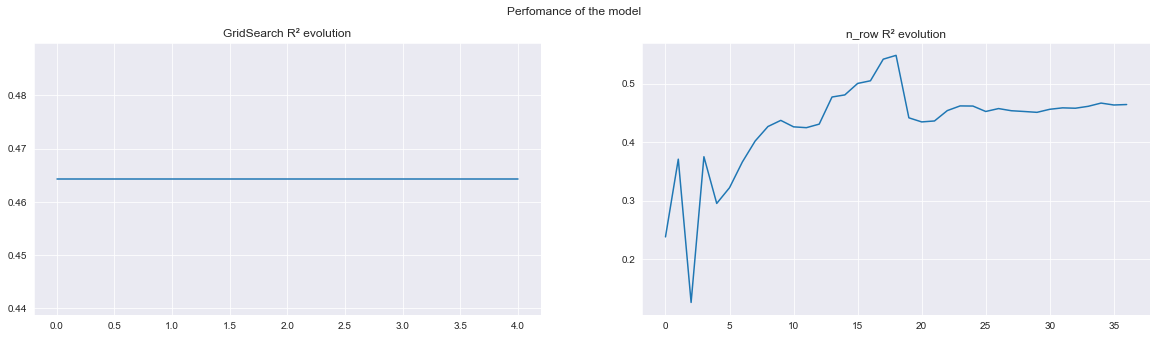

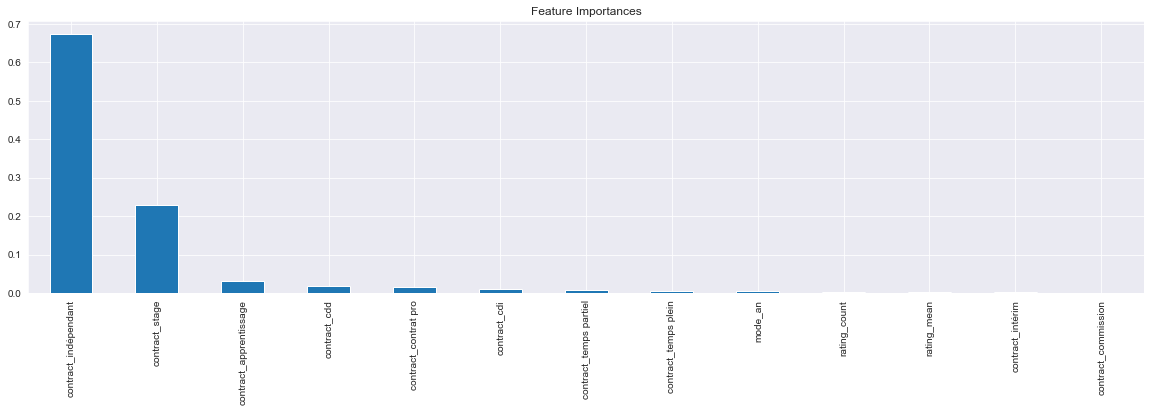

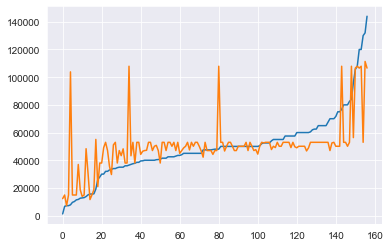

In [30]:
features = list(df.columns[1:14])

plot_searchs(params, np.array(grid_metrics), np.array(n_row_metrics), feature_importances, features)
plot_pred(params, X_train, X_test, y_train, y_test, features)

## with query

In [31]:
features = list(df.columns[1:14]) + list(df.columns[18:])

params, grid_metrics = multi_search(PARAMS, X_train, X_test, y_train, y_test, features, msg=key)
n_row_metrics, feature_importances = n_row_search(params, X_train, X_test, y_train, y_test, features, msg='paris2')

364/364 - 100.00 - paris2



Model Report

Features : ['rating_mean', 'rating_count', 'contract_contrat pro', 'contract_intérim', 'contract_temps plein', 'contract_indépendant', 'contract_cdd', 'contract_temps partiel', 'contract_cdi', 'contract_stage', 'contract_commission', 'contract_apprentissage', 'mode_an', 'query_data+scientist', 'query_business+intelligence', 'query_data+analyst', 'query_developpeur']

Params : {'random_state': 0, 'learning_rate': 0.005, 'n_estimators': 650, 'booster': 'dart', 'objective': 'reg:squarederror', 'max_depth': 6, 'subsample': 1.0, 'gamma': 0}

R2 : 0.47521845706348786
AR2 : 0.41103654174031734
MAE/MEAN : 0.21727516192985188
MSE/MEAN² : 0.1192465713441748
RMSE/MEAN : 0.34532096858455436


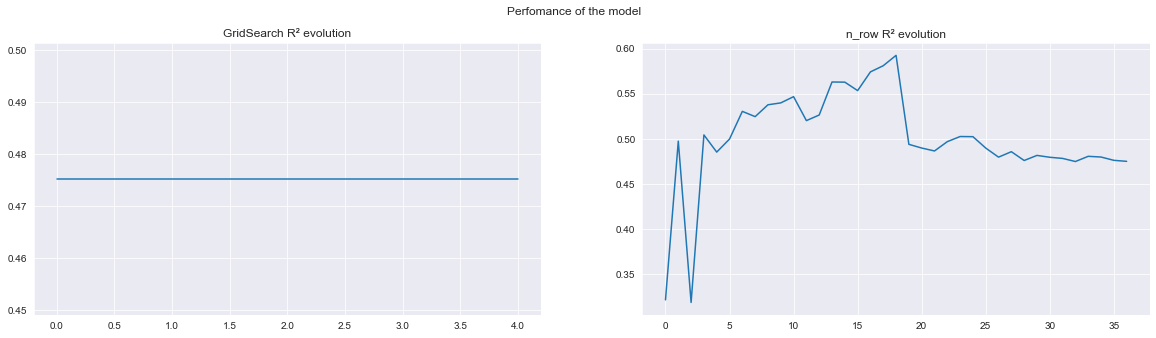

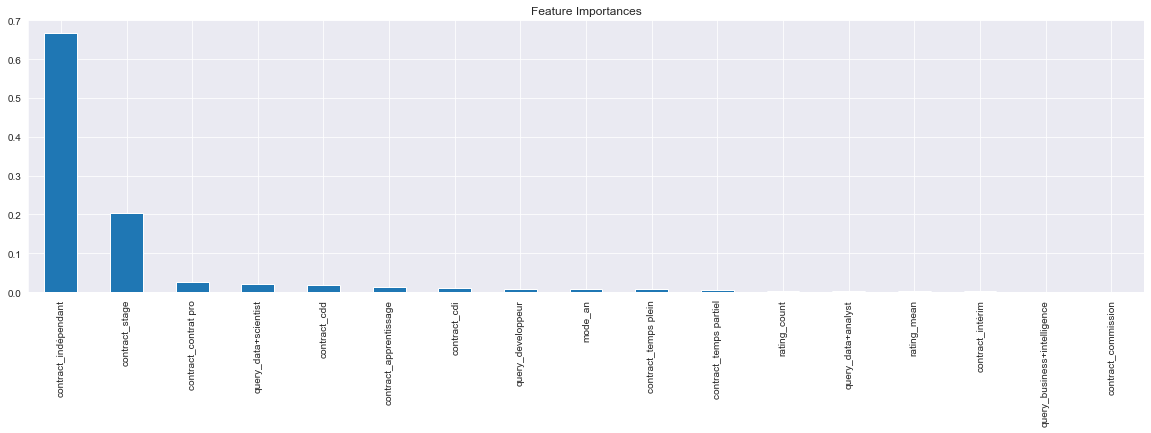

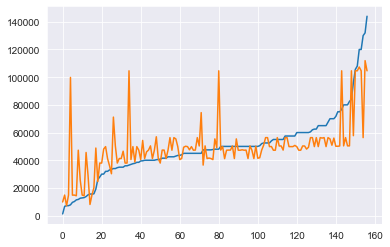

In [32]:
features = list(df.columns[1:14]) + list(df.columns[18:])

plot_searchs(params, np.array(grid_metrics), np.array(n_row_metrics), feature_importances, features)
plot_pred(params, X_train, X_test, y_train, y_test, features)